In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Literal, List, Tuple, Dict
from rich import print as rprint

## 创建学生类

In [2]:
@dataclass
class Student:
    coord: tuple
    status: Literal[0, 1]
    sensitivity: float
    target_volume: float = 0.0
    target_ref_volume: float = 2.0

    prev_neighbor_avg_volume: float = 0.0
    alpha: float = 0.5
    beta: float = 0.5
    gamma: float = 0.5
    lambda_rate: float = 0.1
    epsilon: float = 0.1
    theta_0: float = 0.2

    @property
    def actual_volume(self) -> float:
        return self.status * self.target_volume

    @property
    def theta(self) -> float:
        return self.sensitivity * self.theta_0

ALPHA = 0.5
BETA = 0.5
GAMMA = 0.5
LAMBDA_RATE = 0.1
THETA_0 = 0.2
EPSILON = 0.1
P_ON = 0.8
P_OFF = 0.1
TARGET_REF_VOLUME = 2.0
TARGET_VOLUME = 1.0

In [3]:
def initialize_students(row_num: int, col_num: int) -> dict:
    students_map = {}

    for i in range(row_num):
        for j in range(col_num):
            coord = (i, j)

            students_map[coord] = Student(
                coord=coord,
                status=1,
                sensitivity=1.0,
                alpha=ALPHA,
                beta=BETA,
                gamma=GAMMA,
                theta_0=THETA_0,
                lambda_rate=LAMBDA_RATE,
                epsilon=EPSILON,
                target_volume=TARGET_VOLUME,
                target_ref_volume=TARGET_REF_VOLUME,
                prev_neighbor_avg_volume=0.0
            )

    return students_map

students_map = initialize_students(20, 20)

In [4]:
def on_off_model(student: Student, p_on: float, p_off: float) -> Literal[0, 1]:
    r = np.random.rand()
    if student.status == 0:
        return 0 if r < p_off else 1
    if student.status == 1:
        return 1 if r < p_on else 0
    return 1 - student.status


def get_neighbors_volume(
    student: Student, students_map: Dict[Tuple[int, int], Student]
) -> float:
    x, y = student.coord
    neighbors = (
        (x - 1, y - 1),
        (x - 1, y),
        (x - 1, y + 1),
        (x, y - 1),
        (x, y + 1),
        (x + 1, y - 1),
        (x + 1, y),
        (x + 1, y + 1),
    )
    total = 0.0
    count = 0
    for coord in neighbors:
        s = students_map.get(coord)
        if s is not None:
            total += s.actual_volume
            count += 1
    return total / count if count else 0.0


def update_student_volume(
    student: Student, current_neighbor_avg_volume: float
) -> float:
    if student.status == 0:
        return 0.0

    prev = student.prev_neighbor_avg_volume
    delta_e = current_neighbor_avg_volume - prev
    cur = student.target_volume

    if delta_e >= -student.theta and cur > student.epsilon:
        return (
            cur
            + student.alpha * (current_neighbor_avg_volume - cur)
            + student.beta * (student.target_ref_volume - cur)
        )

    if delta_e <= -student.theta:
        return student.gamma * cur

    if delta_e >= -student.theta and cur <= student.epsilon:
        return cur + student.lambda_rate * (student.target_ref_volume - cur)

    return student.target_volume


def update_student_state(student, students_map, p_on, p_off):
    new_status = on_off_model(student, p_on, p_off)
    current_neighbor_avg_volume = get_neighbors_volume(student, students_map)
    temp_student = student
    temp_student.status = new_status
    new_volume = update_student_volume(temp_student, current_neighbor_avg_volume)
    temp_student.status = student.status
    return {
        "new_status": new_status,
        "new_target_volume": new_volume,
        "new_prev_neighbor_avg_volume": current_neighbor_avg_volume,
    }

In [9]:
all_students_trajectory = []
time_steps = range(100)

for current_t in time_steps:
    updates = {}

    for coord, student in students_map.items():
        update_info = update_student_state(student, students_map, P_ON, P_OFF)
        updates[coord] = update_info

    for coord, info in updates.items():
        student = students_map[coord]
        student.status = info['new_status']
        student.target_volume = info['new_target_volume']
        student.prev_neighbor_avg_volume = info['new_prev_neighbor_avg_volume']

    current_step_data = []
    for student in students_map.values():
        snapshot = {
            "time_step": current_t,
            "coord": student.coord,
            "status": student.status,
            "actual_volume": student.actual_volume,
            "theta_0": student.theta_0
        }
        current_step_data.append(snapshot)

    all_students_trajectory.extend(current_step_data)

df_all_data = pd.DataFrame(all_students_trajectory)

from rich import print as rprint
rprint(df_all_data)

time_step     coord  status  actual_volume  theta_0
0              0    (0, 0)       0       0.000000      0.2
1              0    (0, 1)       0       0.000000      0.2
2              0    (0, 2)       1       1.674091      0.2
3              0    (0, 3)       1       1.750215      0.2
4              0    (0, 4)       0       0.000000      0.2
...          ...       ...     ...            ...      ...
39995         99  (19, 15)       1       1.463684      0.2
39996         99  (19, 16)       0       0.000000      0.2
39997         99  (19, 17)       1       0.643424      0.2
39998         99  (19, 18)       1       0.200000      0.2
39999         99  (19, 19)       0       0.000000      0.2

[40000 rows x 5 columns]

In [15]:
stats_df = (
    df_all_data.groupby("time_step")
    .agg(avg_volume=("actual_volume", "mean"), active_ratio=("status", "mean"))
    .reset_index()
)
rprint(stats_df)

time_step  avg_volume  active_ratio
0           0    0.778937        0.8300
1           1    0.790021        0.8250
2           2    0.745250        0.7900
3           3    0.710165        0.8375
4           4    0.716092        0.8225
..        ...         ...           ...
95         95    0.671079        0.8400
96         96    0.648553        0.8000
97         97    0.666575        0.8125
98         98    0.748997        0.8350
99         99    0.759307        0.7950

[100 rows x 3 columns]

In [16]:
df = df_all_data[df_all_data['time_step'] == 0]
df['status'].mean()

np.float64(0.83)

正在生成 classroom_simulation.gif，请稍候...


KeyboardInterrupt: 

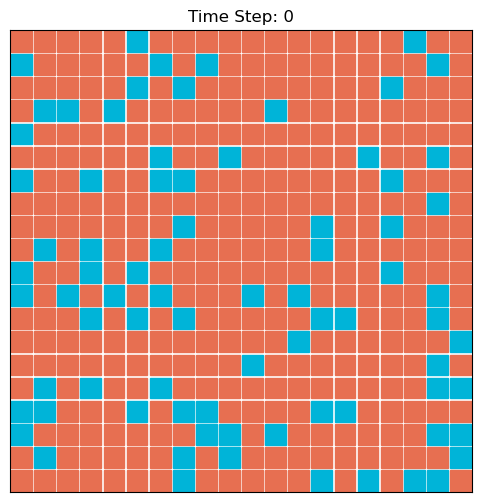

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

RECTANGLE_WIDTH = 0.9
BLANK_WIDTH = 1 - RECTANGLE_WIDTH

def create_simulation_gif(df_data, filename='simulation.gif'):

    max_row = df_data['coord'].apply(lambda x: x[0]).max()
    max_col = df_data['coord'].apply(lambda x: x[1]).max()
    row_num = max_row + 1
    col_num = max_col + 1

    time_steps = df_data['time_step'].unique()

    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame_time):
        ax.clear()

        current_df = df_data[df_data['time_step'] == frame_time]

        ax.set_xlim(0, col_num)
        ax.set_ylim(0, row_num)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Time Step: {frame_time}")

        for _, row in current_df.iterrows():
            coord = row['coord']
            actual_volume = row['actual_volume']
            theta_0 = row['theta_0']

            color = '#e76f51' if actual_volume > theta_0 else '#00b4d8'

            x_bl = coord[1] + BLANK_WIDTH / 2
            y_bl = (row_num - 1 - coord[0]) + BLANK_WIDTH / 2

            rect = plt.Rectangle(
                (x_bl, y_bl), 
                RECTANGLE_WIDTH, 
                RECTANGLE_WIDTH, 
                color=color
            )
            ax.add_patch(rect)

    ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=200)

    print(f"正在生成 {filename}，请稍候...")

    ani.save(filename, writer='pillow', fps=10)
    print(f"生成完成！已保存为 {filename}")
    plt.close()

create_simulation_gif(df_all_data, filename='classroom_simulation.gif')